# Gods Unchained - Exploratory Data Analysis
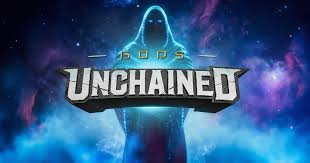


In the competitive world of Gods Unchained, creating an effective deck is crucial to success. A well-balanced deck takes into account **the timing of card distribution**, with some cards ideal for the beginning of the game and others more suitable for the end of the game. Manually classifying each card as “early” or “late” can be time-consuming and subjective.

To address this challenge, we will leverage machine learning to develop a model that can automatically categorize Free God cards based on their attributes (mana cost, attack, health, etc.).

This model will not only help with understanding the right time to launch the card, but will also be made available through an API after the data exploration study.

# Summary
- Libraries Import
- Data Exploration
  - Notebook Configuration
  - Data Loading and First Look
  - Data Cleaning and Preprocessing
  - Analysis
- Feature Engineering
- Model Building
  - Model Selection
  - Model Training and Evaluation
- Conclusion
- References

## Libraries Import

First, I'll import all the requirement libraries to work with machine learning, image plotting, dataframes and more.

In [53]:
# environment and settings
import os
import warnings

# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning and math
from scipy.stats import normaltest

from sklearn.svm import SVC
from sklearn.calibration import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, roc_curve

## Data Exploration
This section will be dedicated to exploring the data, understanding the features, and preparing the data for the machine learning model.

### Notebook Configuration

In [54]:
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 220

collor_pallet = ['#069FFE', '#00BDE3',
                 '#196CFE', '#FCAC1E', '#F911A4', '#FF4C00']
sns.set_palette(collor_pallet)
sns.set_style("whitegrid")

_path = os.path.abspath(os.path.dirname(os.path.abspath(os.getcwd())))

### Data Loading and First Look

In [55]:
train_dataframe = pd.read_csv(_path + '/data/train.csv')
test_dataframe = pd.read_csv(_path + '/data/test.csv')

raw_train = train_dataframe.copy()
raw_test = test_dataframe.copy()

The first step is to load the data and take a look at the first rows to understand the structure of the dataset.

To do it, I'll use the `pandas` library to load the data and the `head()` method to display the first rows.

As an alternative to `pandas` library we could use the `pyspark` library, but in this case the dataset is small and `pandas` is more than enough.

In [56]:
train_dataframe.head()

,id,name,mana,attack,health,type,god,strategy
0,1118,Firewine,5,0,0,spell,nature,early
1,1036,Leyhoard Hatchling,10,2,1,creature,magic,late
2,244,Aetherfuel Alchemist,6,4,4,creature,neutral,late
3,215,Millenium Matryoshka,4,2,2,creature,neutral,late
4,87013,Poison Peddler,4,1,3,creature,neutral,late


In [57]:
train_dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,788.0,18138.823604,36607.267608,1.0,256.5,902.0,1196.25,100920.0
mana,788.0,3.572335,2.190100,0.0,2.0,3.0,5.00,16.0
attack,788.0,2.140863,2.215047,0.0,0.0,2.0,3.00,13.0
health,788.0,2.583756,2.455053,0.0,0.0,2.0,4.00,17.0


In [58]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        788 non-null    int64 
 1   name      788 non-null    object
 2   mana      788 non-null    int64 
 3   attack    788 non-null    int64 
 4   health    788 non-null    int64 
 5   type      788 non-null    object
 6   god       788 non-null    object
 7   strategy  788 non-null    object
dtypes: int64(4), object(4)
memory usage: 49.4+ KB


In [59]:
train_dataframe.dtypes

id           int64
name        object
mana         int64
attack       int64
health       int64
type        object
god         object
strategy    object
dtype: object

In [60]:
for col in train_dataframe.columns:
    if col not in ['id', 'name']:
        print(col, sorted(train_dataframe[col].unique()))
        print("\n")

mana [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16]


attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


health [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 17]


type ['creature', 'god power', 'spell', 'weapon']


god ['death', 'deception', 'light', 'magic', 'nature', 'neutral', 'war']


strategy ['early', 'late']




In [61]:
train_dataframe['strategy'].value_counts()

strategy
early    432
late     356
Name: count, dtype: int64

In [62]:
print(f'Dataframe shape: {train_dataframe.shape}')
print(f'Rows size: {train_dataframe.shape[0]}')
print(f'Complete row size: {train_dataframe.dropna().shape[0]}')
print(
    f'Does the dataset have incomplete values? {train_dataframe.isnull().values.any()}')
print(f'Null values: {train_dataframe.isnull().sum().sum()}')

Dataframe shape: (788, 8)
Rows size: 788
Complete row size: 788
Does the dataset have incomplete values? False
Null values: 0


In the first contact with the dataset, it was possible to have some insights, among which we can mention:
 - The dataset is made up of 788 rows and 8 columns, also considering the response variable `strategy`, which has 432 cards classified as **early** and 356 cards classified as **late**;
 - There is no missing data in the training dataset, so it will not be necessary to carry out any processing in this regard;
 - Althoug the `strategy` column is shown as `object`, it can be considered as a `boolena` type, since it has only two values;

### Data Cleaning and Preprocessing
The next step is to clean the data and prepare it for the machine learning model.

This step is important to ensure that the model can learn from the data and make accurate predictions.

In [63]:
def to_bool(df, col, conditional):
    df[col] = df[col] == conditional
    return df

In [64]:
train_dataframe = to_bool(train_dataframe, 'strategy', 'late')

In [65]:
train_dataframe.dtypes

id           int64
name        object
mana         int64
attack       int64
health       int64
type        object
god         object
strategy      bool
dtype: object

### Analysis
In this section, I'll analyze the data to understand the distribution of the features and the relationship between the features and the target variable.

The analysis will help to identify patterns in the data and understand how the features are related to the target variable.

In an initial analysis I will divide the columns of the dataset into categorical, numerical, Boolean and continuous, in addition to raising some hypotheses of values that contribute to the objective of the study, for example, observing outliers in numerical fields, like `attack`, `health` and `mana`.

In [66]:
categorical_cols = [
    col for col in train_dataframe.columns if train_dataframe[col].dtypes == 'O']
boolean_cols = [
    col for col in train_dataframe.columns if train_dataframe[col].dtypes == 'bool']
not_cat_cols = [col for col in train_dataframe.columns if train_dataframe[col].dtypes !=
                'O' and train_dataframe[col].dtypes != 'bool']

In [67]:
print('Booleans: {0}\nCategorical: {1}\nNumerical/Continuous:{2}'.format(
    boolean_cols, categorical_cols, not_cat_cols))

Booleans: ['strategy']
Categorical: ['name', 'type', 'god']
Numerical/Continuous:['id', 'mana', 'attack', 'health']


Text(0, 0.5, 'Attack')

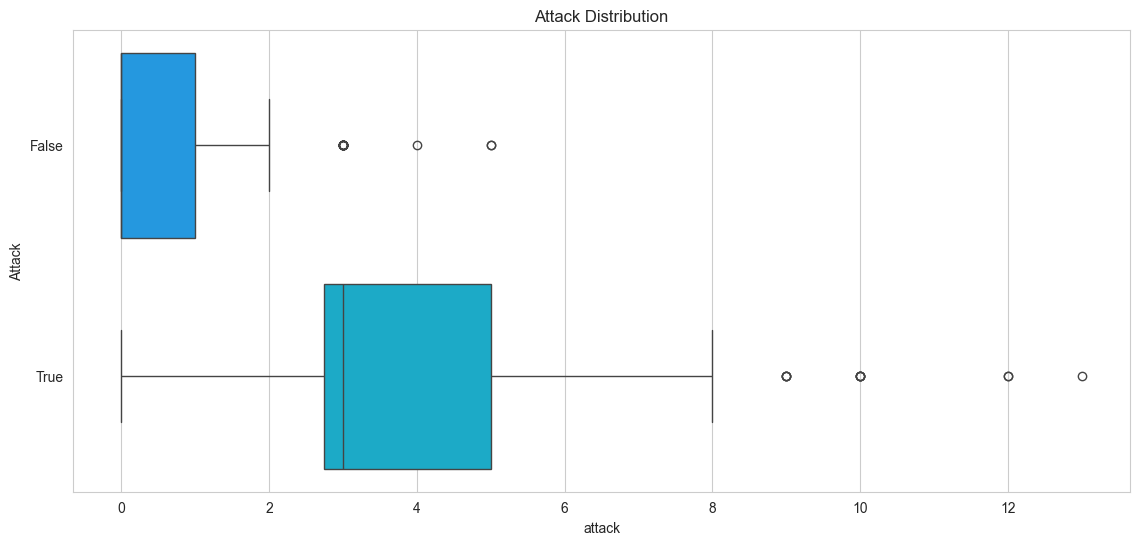

In [68]:
plt.figure(figsize=(30, 6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(x='attack', y='strategy', data=train_dataframe,
                  ax=plt.gca(), orient='h', palette=collor_pallet[0:2])
fig.set_title('Attack Distribution')
fig.set_ylabel('Attack')

Text(0, 0.5, 'Mana')

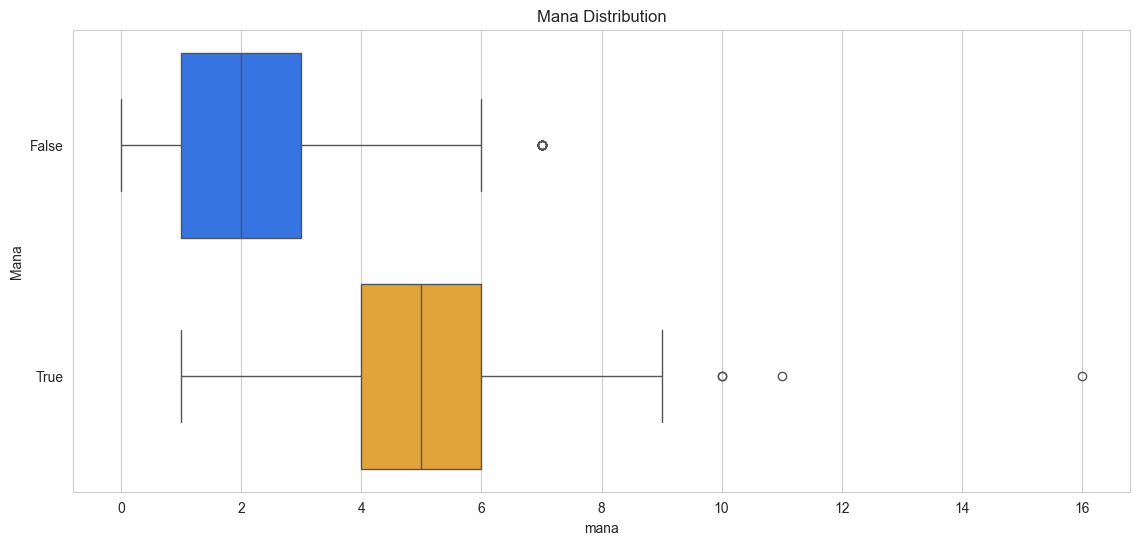

In [69]:
plt.figure(figsize=(30, 6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(x='mana', y='strategy', data=train_dataframe,
                  ax=plt.gca(), orient='h', palette=collor_pallet[2:4])
fig.set_title('Mana Distribution')
fig.set_ylabel('Mana')

Text(0, 0.5, 'Health')

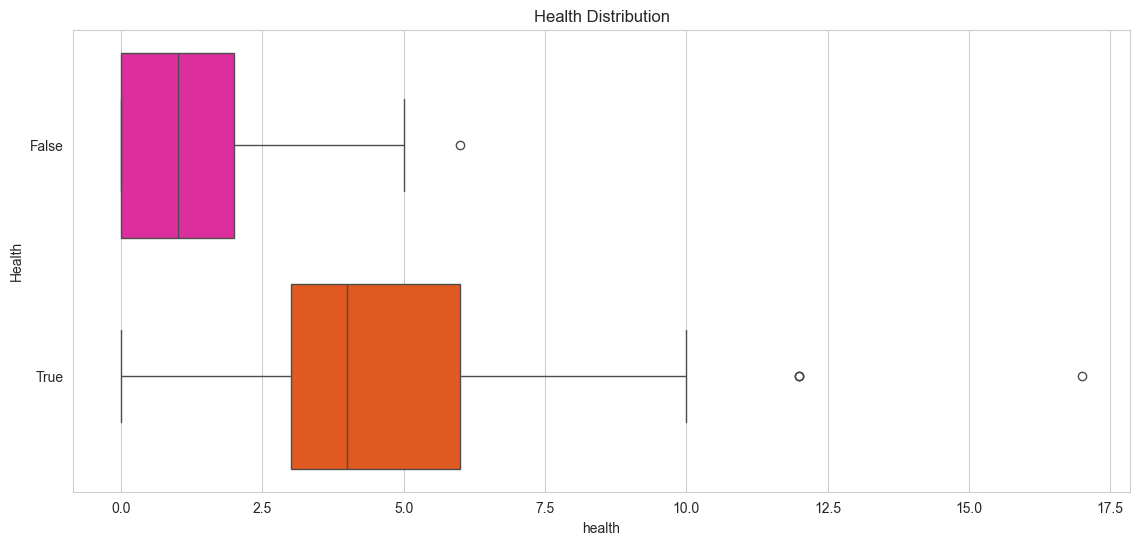

In [70]:
plt.figure(figsize=(30, 6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(x='health', y='strategy', data=train_dataframe,
                  ax=plt.gca(), orient='h', palette=collor_pallet[4:6])
fig.set_title('Health Distribution')
fig.set_ylabel('Health')

Text(0.5, 1.0, 'Health Distribution')

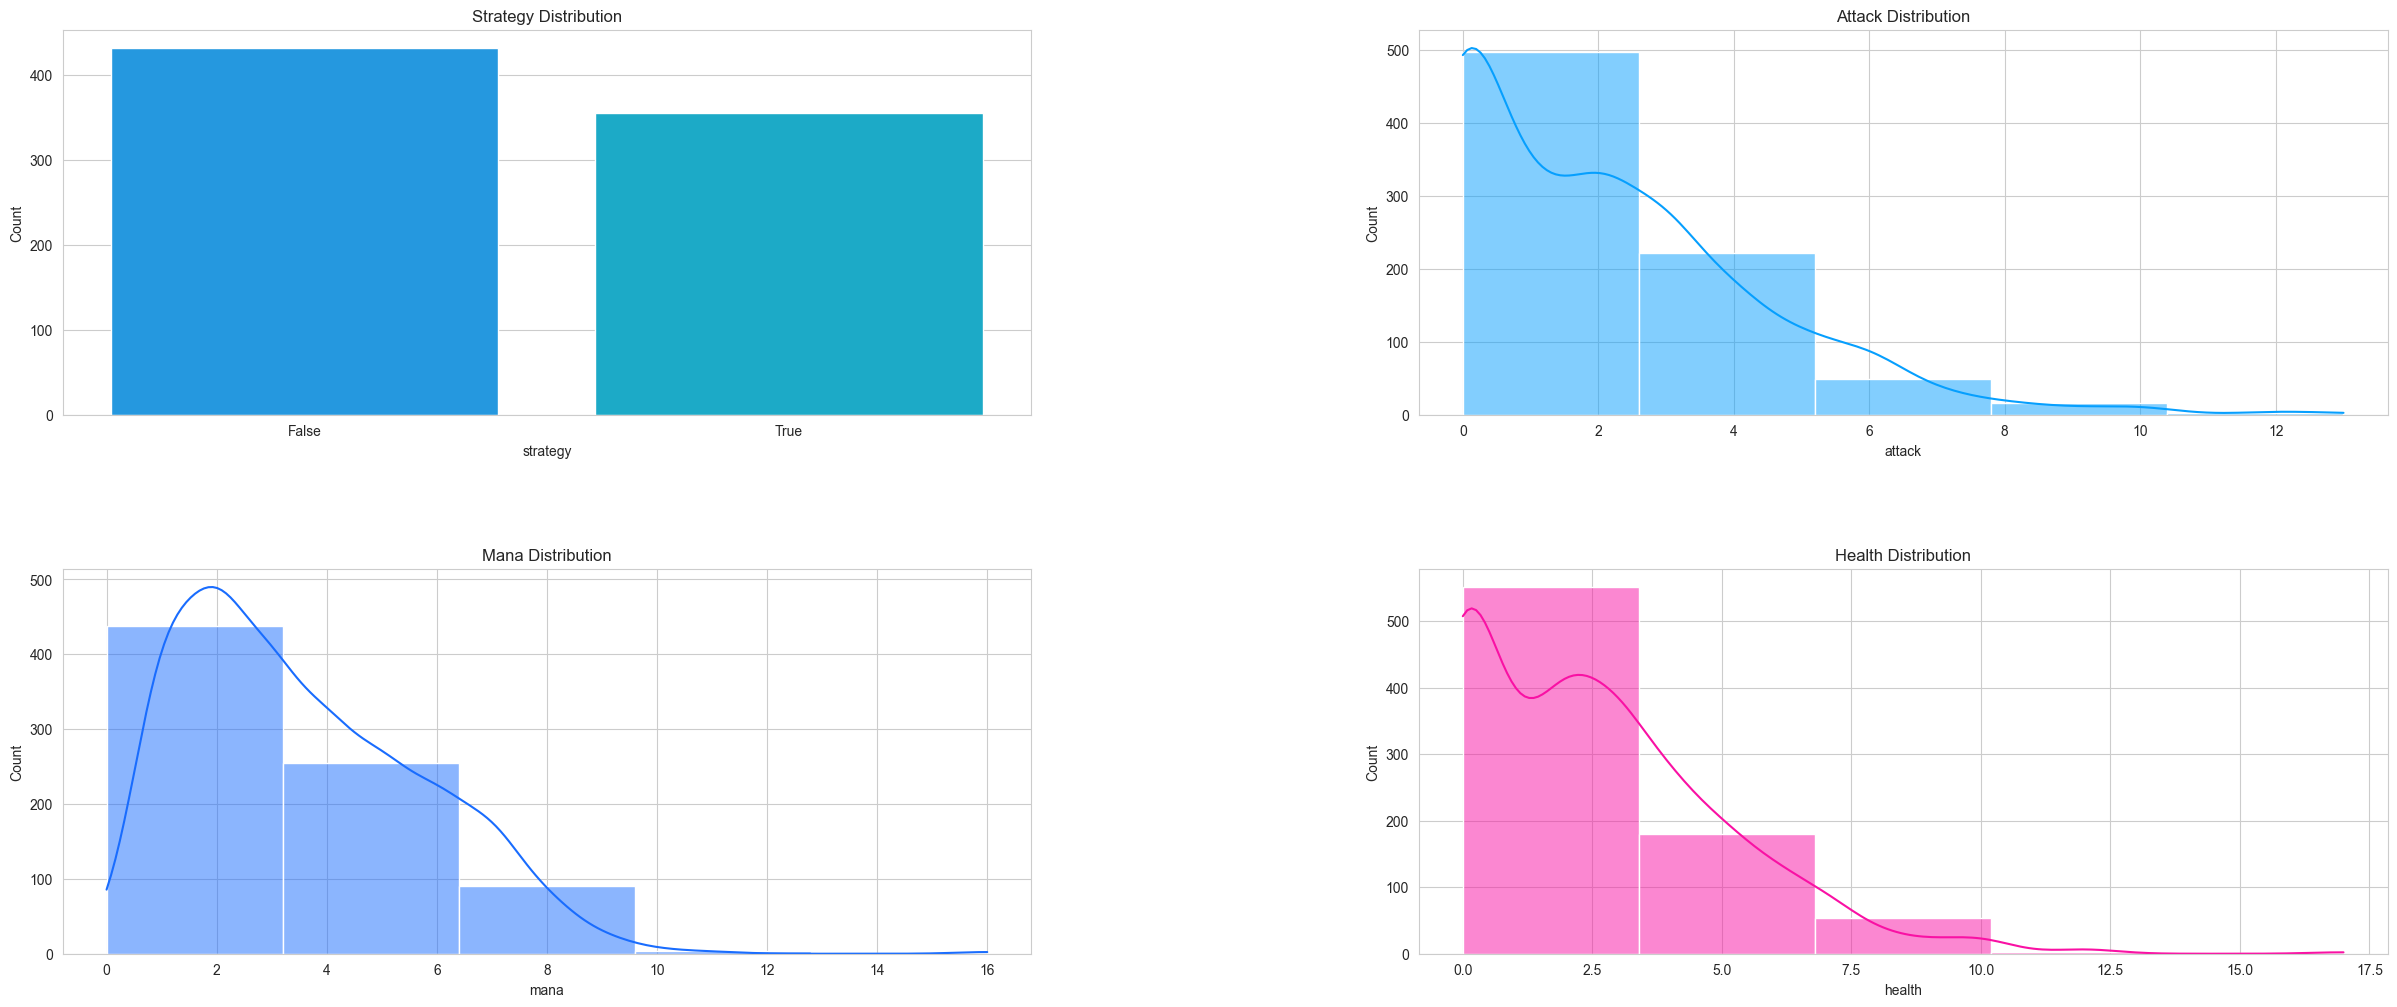

In [71]:
plt.figure(figsize=(30, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 2, 1)
fig = sns.countplot(x='strategy', data=train_dataframe, palette=collor_pallet)
fig.set_title('Strategy Distribution')
fig.set_ylabel('Count')

plt.subplot(2, 2, 2)
sns.histplot(train_dataframe['attack'], kde=True,
             bins=5, color=collor_pallet[0])
plt.title('Attack Distribution')

plt.subplot(2, 2, 3)
sns.histplot(train_dataframe['mana'], kde=True, bins=5, color=collor_pallet[2])
plt.title('Mana Distribution')

plt.subplot(2, 2, 4)
sns.histplot(train_dataframe['health'], kde=True,
             bins=5, color=collor_pallet[4])
plt.title('Health Distribution')

In this step, we will investigate the distributions and correlation matrices, so that we have a notion of which columns have the greatest dependence on each other, in addition to deepening the knowledge of the data, understanding the ranges, bottlenecks and similar factors in the set of data.

In [72]:
corr_matrix = train_dataframe[not_cat_cols + boolean_cols].corr()
corr_matrix

,id,mana,attack,health,strategy
id,1.000000,-0.214055,-0.081191,-0.126601,-0.175537
mana,-0.214055,1.000000,0.524499,0.530001,0.618932
attack,-0.081191,0.524499,1.000000,0.784672,0.690988
health,-0.126601,0.530001,0.784672,1.000000,0.697572
strategy,-0.175537,0.618932,0.690988,0.697572,1.000000


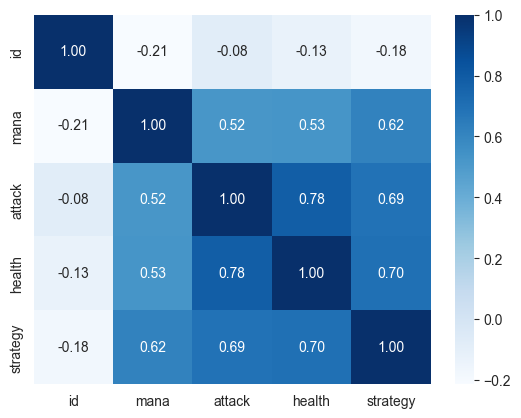

In [73]:
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.show()

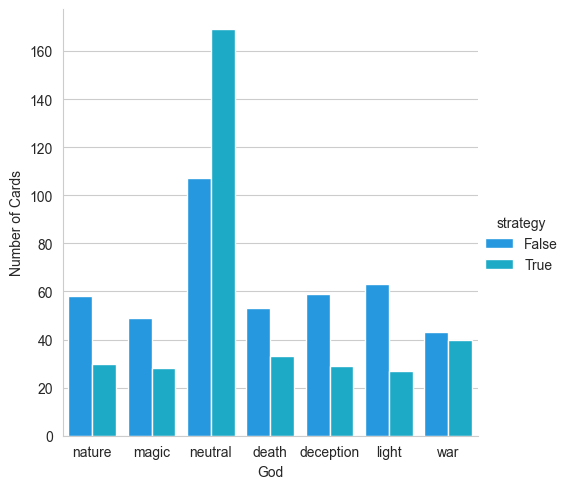

In [74]:
fig = sns.catplot(x='god', hue='strategy', data=train_dataframe,
                  kind='count', palette=collor_pallet)
fig.set_xlabels('God')
fig.set_ylabels('Number of Cards')
fig.set_titles('God Distribution')
plt.show()

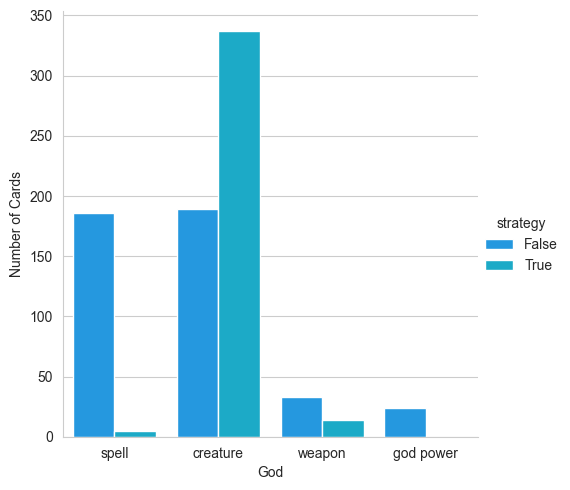

In [75]:
fig = sns.catplot(x='type', hue='strategy', data=train_dataframe,
                  kind='count', palette=collor_pallet)
fig.set_xlabels('God')
fig.set_ylabels('Number of Cards')
fig.set_titles('God Distribution')
plt.show()

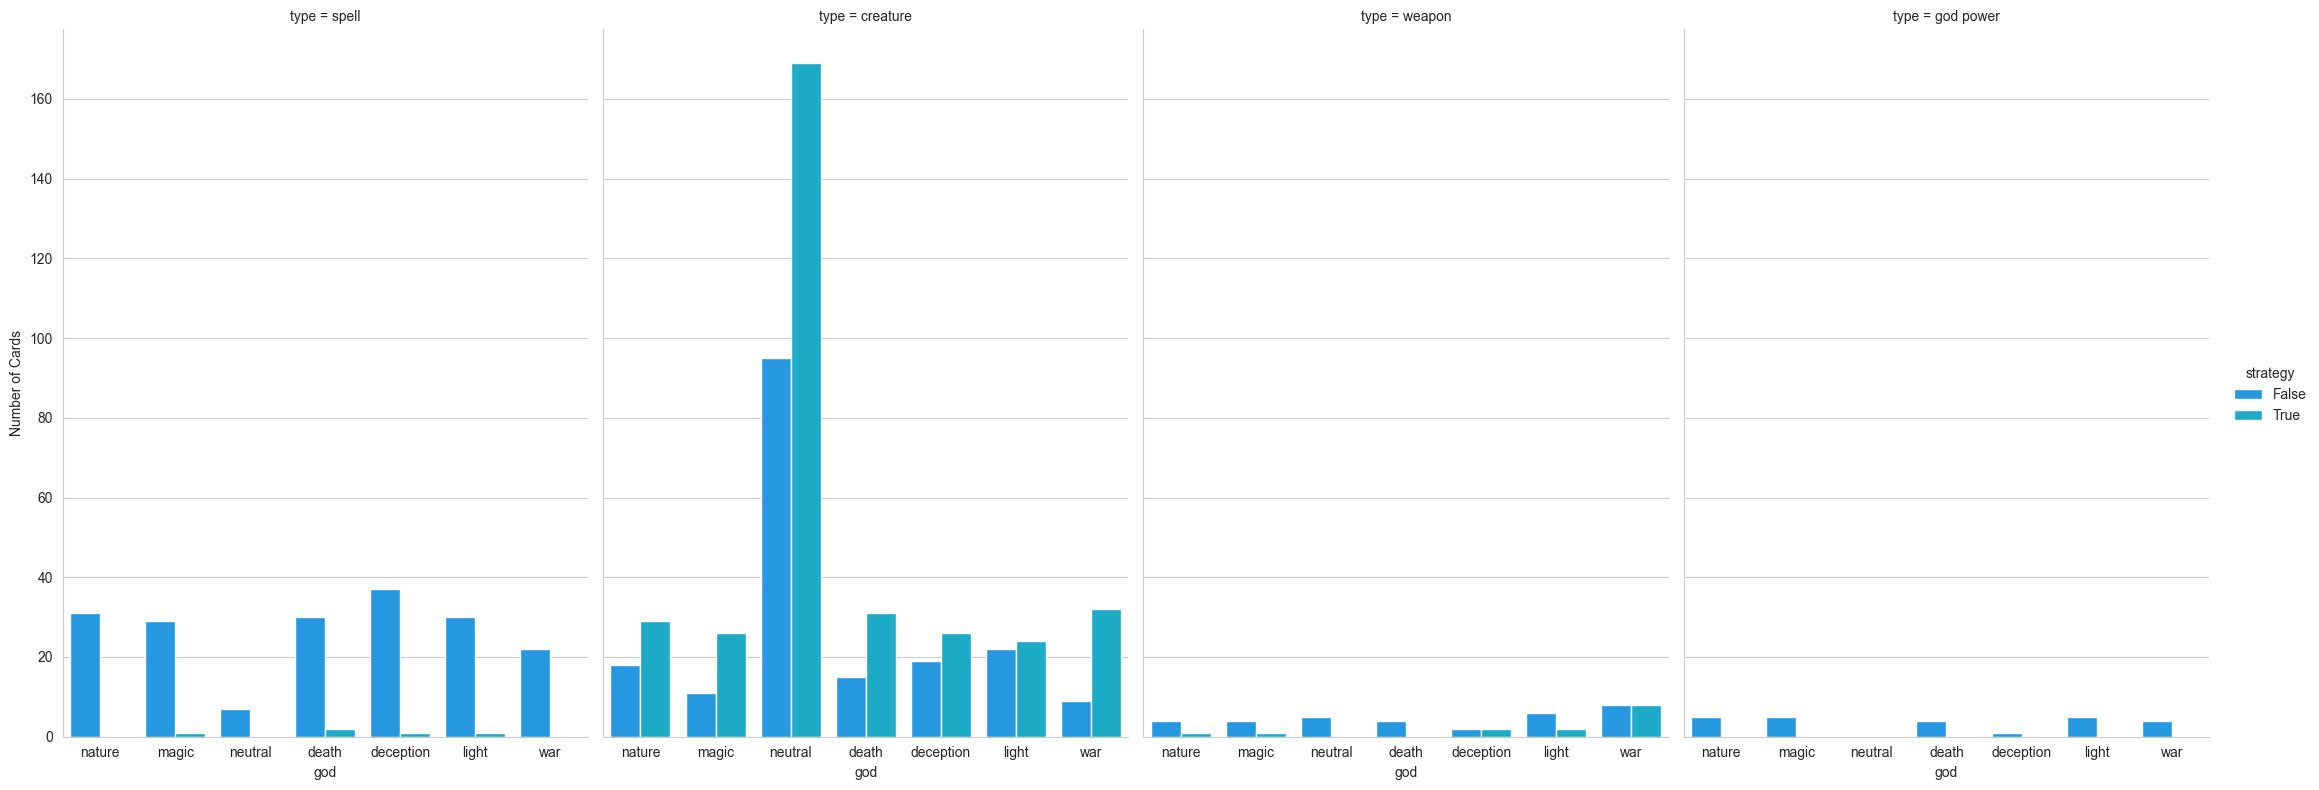

In [76]:
fig = sns.catplot(x='god', hue='strategy', col='type', data=train_dataframe,
                  kind='count', height=8, aspect=0.7, palette=collor_pallet)
fig.set_ylabels('Number of Cards')
plt.show()

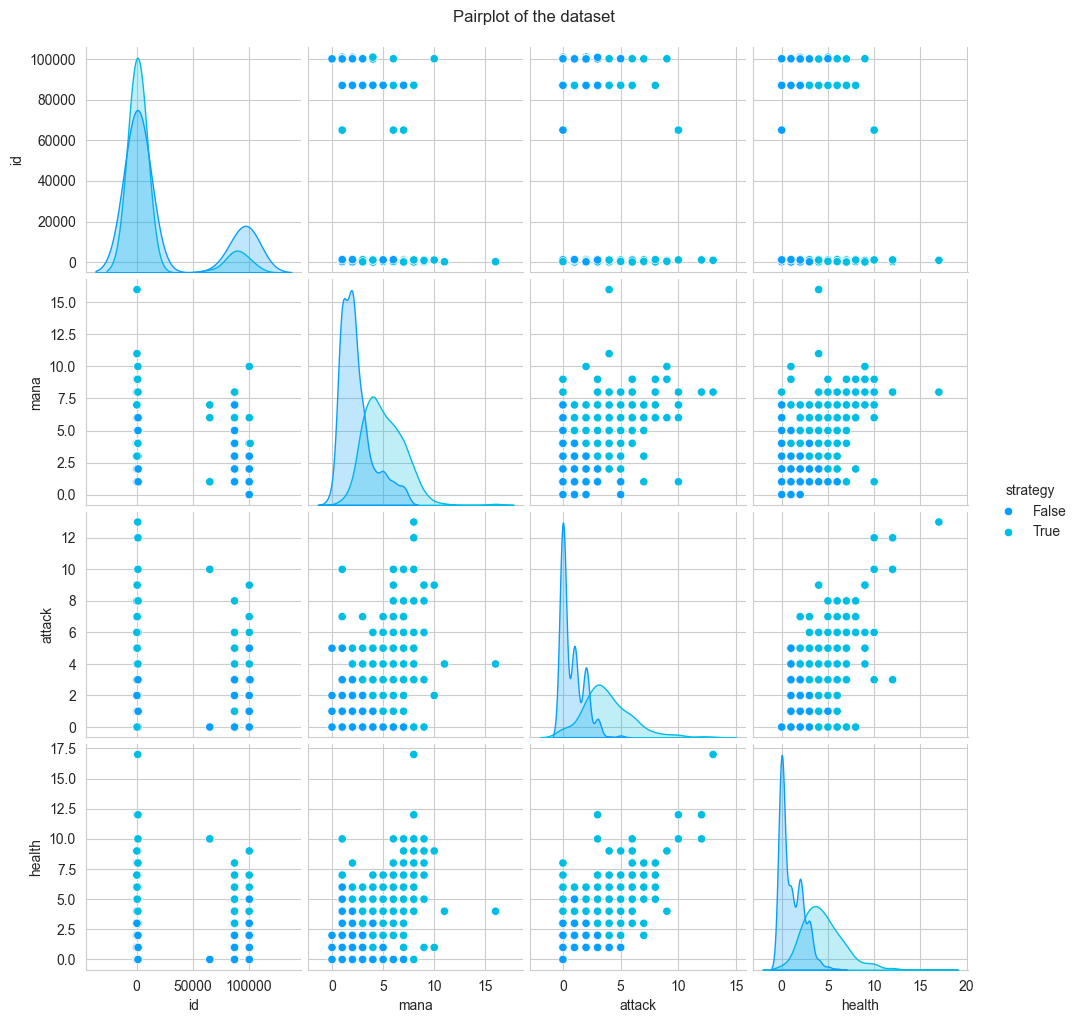

In [77]:
fig = sns.pairplot(train_dataframe, hue='strategy', palette=collor_pallet)
fig.fig.suptitle('Pairplot of the dataset', y=1.02)
plt.show()


Dataset with Attack and Mana
LogisticRegression score: 0.94
LinearSVC score: 0.93
KBinsDiscretizer + LogisticRegression score: 0.95
KBinsDiscretizer + LinearSVC score: 0.93
GradientBoostingClassifier score: 0.95
SVC score: 0.94

Dataset with Attack and Health
LogisticRegression score: 0.91
LinearSVC score: 0.91
KBinsDiscretizer + LogisticRegression score: 0.92
KBinsDiscretizer + LinearSVC score: 0.92
GradientBoostingClassifier score: 0.91
SVC score: 0.91

Dataset with Mana and Health
LogisticRegression score: 0.90
LinearSVC score: 0.90
KBinsDiscretizer + LogisticRegression score: 0.93
KBinsDiscretizer + LinearSVC score: 0.94
GradientBoostingClassifier score: 0.94
SVC score: 0.95


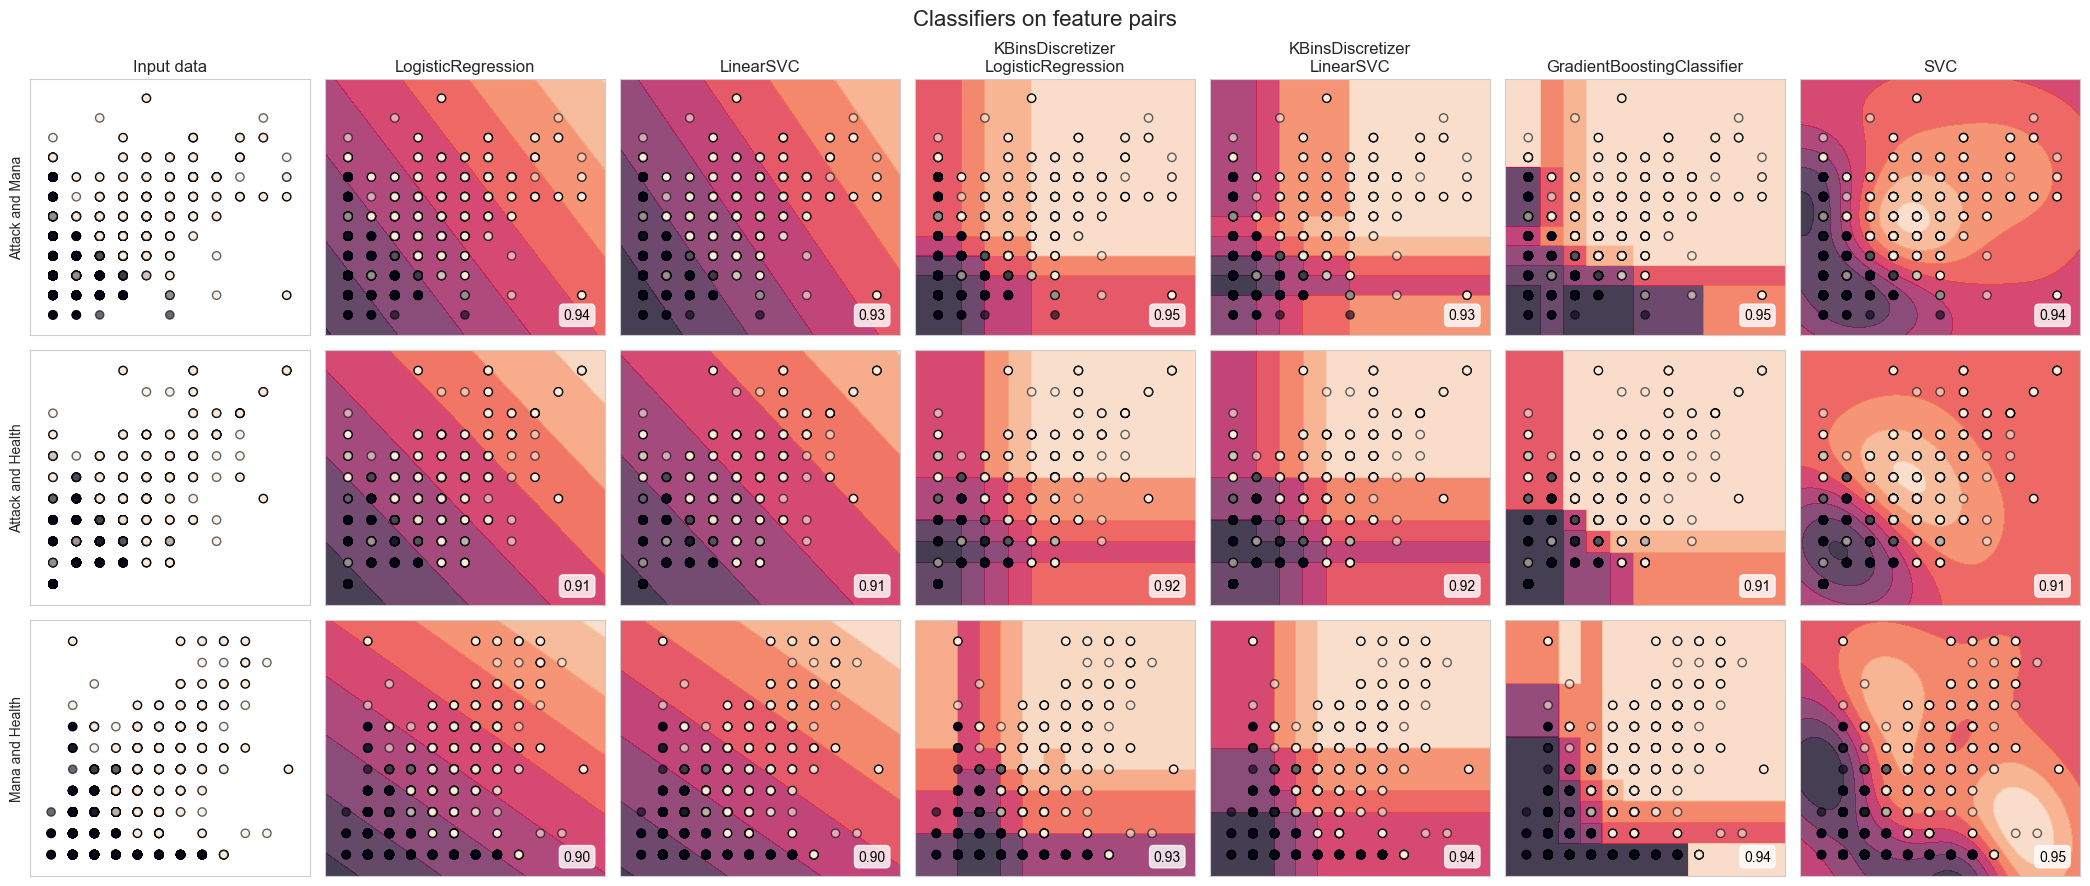

In [78]:
meshResolution = 0.02


def get_name(estimator):
    name = estimator.__class__.__name__
    if name == "Pipeline":
        name = [get_name(est[1]) for est in estimator.steps]
        name = " + ".join(name)
    return name


classifiers = [
    (
        make_pipeline(StandardScaler(), LogisticRegression(random_state=0)),
        {"logisticregression__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(StandardScaler(), LinearSVC(random_state=0)),
        {"linearsvc__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot", random_state=0),
            LogisticRegression(random_state=0),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "logisticregression__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot", random_state=0),
            LinearSVC(random_state=0),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "linearsvc__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(), GradientBoostingClassifier(n_estimators=5, random_state=0)
        ),
        {"gradientboostingclassifier__learning_rate": np.logspace(-2, 0, 5)},
    ),
    (
        make_pipeline(StandardScaler(), SVC(random_state=0)),
        {"svc__C": np.logspace(-1, 1, 3)},
    ),
]

names = [get_name(e).replace("StandardScaler + ", "") for e, _ in classifiers]

datasets = [
    (train_dataframe[['attack', 'mana']],
     train_dataframe['strategy'], "Attack and Mana"),
    (train_dataframe[['attack', 'health']],
     train_dataframe['strategy'], "Attack and Health"),
    (train_dataframe[['mana', 'health']],
     train_dataframe['strategy'], "Mana and Health"),
]

fig, axes = plt.subplots(
    nrows=len(datasets),
    ncols=len(classifiers) + 1,
    figsize=(21, 3 * len(datasets))
)

for ds_cnt, (X, y, ds_title) in enumerate(datasets):
    print(f"\nDataset with {ds_title}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=0
    )

    x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
    y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, meshResolution), np.arange(
            y_min, y_max, meshResolution
        )
    )

    ax = axes[ds_cnt, 0]
    ax.set_ylabel(ds_title)
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k"
    )
    ax.scatter(
        X_test.iloc[:, 0], X_test.iloc[:, 1],
        c=y_test, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    for est_idx, (name, (estimator, params)) in enumerate(zip(names, classifiers), 1):
        ax = axes[ds_cnt, est_idx]
        clf = GridSearchCV(estimator, params)
        with ignore_warnings(category=ConvergenceWarning):
            clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        print(f"{name} score: {score:.2f}")

        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.8)

        ax.scatter(
            X_train.iloc[:, 0], X_train.iloc[:, 1],
            c=y_train, edgecolors="k"
        )
        ax.scatter(
            X_test.iloc[:, 0], X_test.iloc[:, 1],
            c=y_test, alpha=0.6, edgecolors="k"
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        if ds_cnt == 0:
            ax.set_title(name.replace(" + ", "\n"))
        ax.text(
            0.95,
            0.06,
            f"{score:.2f}",
            ha="right",
            size=10,
            bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
            transform=ax.transAxes,
            color="black"
        )

plt.subplots_adjust(left=0.02, right=0.98, top=0.90, bottom=0.02)
plt.suptitle("Classifiers on feature pairs", size=16)

plt.tight_layout()
plt.show()

In [79]:
train_dataframe.groupby('strategy')['attack'].value_counts()

strategy  attack
False     0         234
          1          99
          2          76
          3          20
          5           2
          4           1
True      3          91
          4          67
          2          58
          5          41
          6          36
          0          17
          1          14
          7          13
          8           7
          10          5
          9           4
          12          2
          13          1
Name: count, dtype: int64

In [80]:
train_dataframe.groupby('strategy')['type'].value_counts()

strategy  type     
False     creature     189
          spell        186
          weapon        33
          god power     24
True      creature     337
          weapon        14
          spell          5
Name: count, dtype: int64

In [81]:
print(
    f'Attack distribution is normal? {normaltest(train_dataframe["attack"]).pvalue < 0.05}')
print(
    f'Mana distribution is normal? {normaltest(train_dataframe["mana"]).pvalue < 0.05}')
print(
    f'Health distribution is normal? {normaltest(train_dataframe["health"]).pvalue < 0.05}')
print(
    f'Attack and Mana distribution is normal? {normaltest(train_dataframe["attack"] + train_dataframe["mana"]).pvalue < 0.05}')
print(
    f'Attack and Health distribution is normal? {normaltest(train_dataframe["attack"] + train_dataframe["health"]).pvalue < 0.05}')
print(
    f'Mana and Health distribution is normal? {normaltest(train_dataframe["mana"] + train_dataframe["health"]).pvalue < 0.05}')
print(
    f'Attack, Mana and Health distribution is normal? {normaltest(train_dataframe["attack"] + train_dataframe["mana"] + train_dataframe["health"]).pvalue < 0.05}')

Attack distribution is normal? True
Mana distribution is normal? True
Health distribution is normal? True
Attack and Mana distribution is normal? True
Attack and Health distribution is normal? True
Mana and Health distribution is normal? True
Attack, Mana and Health distribution is normal? True


Performing the analysis of distributions and correlation, it was possible to see some more insights, such as:
- It is possible to observe a strong correlation, respectively, between the fields `attack` and `health`, `strategy` and `health`, `attack` and `strategy`;
- With the discretization plot, it is possible to observe that:
  - The fields `attack` and `mana` have non-linear distributions profile, because the best discretizers was GradientBoostingClassifier and SVC;
  - The fields `health` and `attack` have the K-Bins discretizer as the best option, combined with LogisticRegression and LinearSVC;
  - The fields `health` and `mana` have a non-linear distribution profile, with the best discretizer being GradientBoostingClassifier and SVC;
- It is possible to observe that the fields `attack` and `health` have the bigest concentration of values around the starting point;
- The distribuition of data is considered normal to the fields `attack`, `health` and `mana`, but it is possible to observe some outliers in the fields.
- Most cards have a `mana` cost below 10, with a higher frequency in the 1-3 range;
- `Attack` values are skewed towards lower values, with a peak at 0 and 1;
- `Health` values are also skewed towards lower values, with peaks around 0, 1, and 2;
- The majority of cards `types` are **creatures**, followed by **spells**. Other types are much less frequent;
- **Neutral** cards are the most common in the `god` column, followed by cards associated with different gods, with no single god dominating the distribution;
- There are no **god power** `god` cards in the **late** `strategy` column.

## Feature Engineering
In this section, I'll create new features that can help the model learn from the data and make accurate predictions.

In [82]:
train_dataframe = train_dataframe.sample(
    frac=1,
    random_state=237
).reset_index(drop=True)

In [83]:
train_dataframe['attack'] = train_dataframe['attack'].apply(
    lambda x: np.log(x))
train_dataframe['mana'] = train_dataframe['mana'].apply(lambda x: np.log(x))
train_dataframe['health'] = train_dataframe['health'].apply(
    lambda x: np.log(x))

In [84]:
train_dataframe['attack_mana'] = train_dataframe['attack'] + \
    train_dataframe['mana']
train_dataframe['attack_health'] = train_dataframe['attack'] + \
    train_dataframe['health']
train_dataframe['mana_health'] = train_dataframe['mana'] + \
    train_dataframe['health']
train_dataframe['attack_mana_health'] = train_dataframe['attack'] + \
    train_dataframe['mana'] + train_dataframe['health']

In [85]:
train_dataframe['att_greater_5'] = train_dataframe['attack'] > 5
train_dataframe['mana_greater_7'] = train_dataframe['mana'] > 7
train_dataframe['health_greater_6'] = train_dataframe['health'] > 5
train_dataframe['att_greater_mana'] = train_dataframe['attack'] > train_dataframe['mana']
train_dataframe['att_greater_health'] = train_dataframe['attack'] > train_dataframe['health']
train_dataframe['mana_greater_health'] = train_dataframe['mana'] > train_dataframe['health']

train_dataframe['att_greater_5'] = train_dataframe['att_greater_5'].astype(int)
train_dataframe['mana_greater_7'] = train_dataframe['mana_greater_7'].astype(
    int)
train_dataframe['health_greater_6'] = train_dataframe['health_greater_6'].astype(
    int)
train_dataframe['att_greater_mana'] = train_dataframe['att_greater_mana'].astype(
    int)
train_dataframe['att_greater_health'] = train_dataframe['att_greater_health'].astype(
    int)
train_dataframe['mana_greater_health'] = train_dataframe['mana_greater_health'].astype(
    int)

In [86]:
train_dataframe = pd.get_dummies(
    train_dataframe,
    columns=['god', 'type'],
    drop_first=True,
    prefix=['god', 'type'],
    prefix_sep='_'
)
train_dataframe.head()

,id,name,mana,attack,health,strategy,attack_mana,attack_health,mana_health,attack_mana_health,...,mana_greater_health,god_deception,god_light,god_magic,god_nature,god_neutral,god_war,type_god power,type_spell,type_weapon
0,376,Iron-tooth Goblin,0.693147,0.693147,0.693147,False,1.386294,1.386294,1.386294,2.079442,...,0,False,False,False,False,True,False,False,False,False
1,914,Aeona's Defection,1.609438,-inf,-inf,False,-inf,-inf,-inf,-inf,...,1,False,False,False,True,False,False,False,True,False
2,263,Crimson Oni,1.386294,1.791759,1.609438,True,3.178054,3.401197,2.995732,4.787492,...,0,False,False,False,False,False,False,False,False,False
3,1057,Battle Cleric,1.609438,0.693147,0.693147,True,2.302585,1.386294,2.302585,2.995732,...,1,False,True,False,False,False,False,False,False,False
4,1123,Guerilla Training,0.693147,-inf,-inf,False,-inf,-inf,-inf,-inf,...,1,False,False,False,True,False,False,False,True,False


<Axes: >

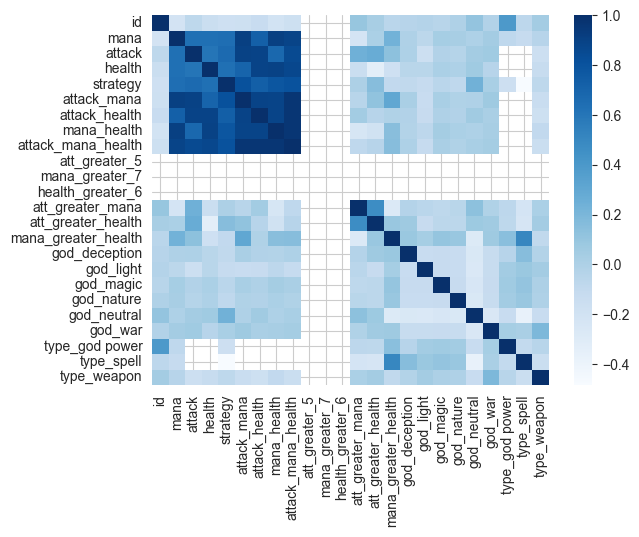

In [87]:
train_dataframe.drop('name', axis=1, inplace=True)
corr_matrix = train_dataframe.corr()
sns.heatmap(corr_matrix, cmap='Blues', fmt=".2f")

A way to reduce the number of features and improve the model's performance is using something to choose the best features.

In this case, I'll show the features chosen by three different methods: `SelectKBest` and `Mutual Information`, but I'll use only the `Mutual Information` method to select the best features.

In [88]:
train_dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
train_dataframe['attack'] = train_dataframe['attack'].fillna(
    train_dataframe['attack'].mean())
train_dataframe['mana'] = train_dataframe['mana'].fillna(
    train_dataframe['mana'].mean())
train_dataframe['health'] = train_dataframe['health'].fillna(
    train_dataframe['health'].mean())
train_dataframe['attack_mana'] = train_dataframe['attack_mana'].fillna(
    train_dataframe['attack_mana'].mean())
train_dataframe['attack_health'] = train_dataframe['attack_health'].fillna(
    train_dataframe['attack_health'].mean())
train_dataframe['mana_health'] = train_dataframe['mana_health'].fillna(
    train_dataframe['mana_health'].mean())
train_dataframe['attack_mana_health'] = train_dataframe['attack_mana_health'].fillna(
    train_dataframe['attack_mana_health'].mean())

### SelectKBest
The `SelectKBest` method selects the `k` best features based on a scoring function.

('attack_mana_health', 192.90500920601278)
('mana_health', 144.91037613043042)
('attack_mana', 144.2699076506875)
('mana', 133.27924334029575)
('attack_health', 116.05697458589944)
('attack', 64.00187565167143)
('health', 57.523697903414)
('god_neutral', nan)
('type_god power', nan)
('type_spell', nan)


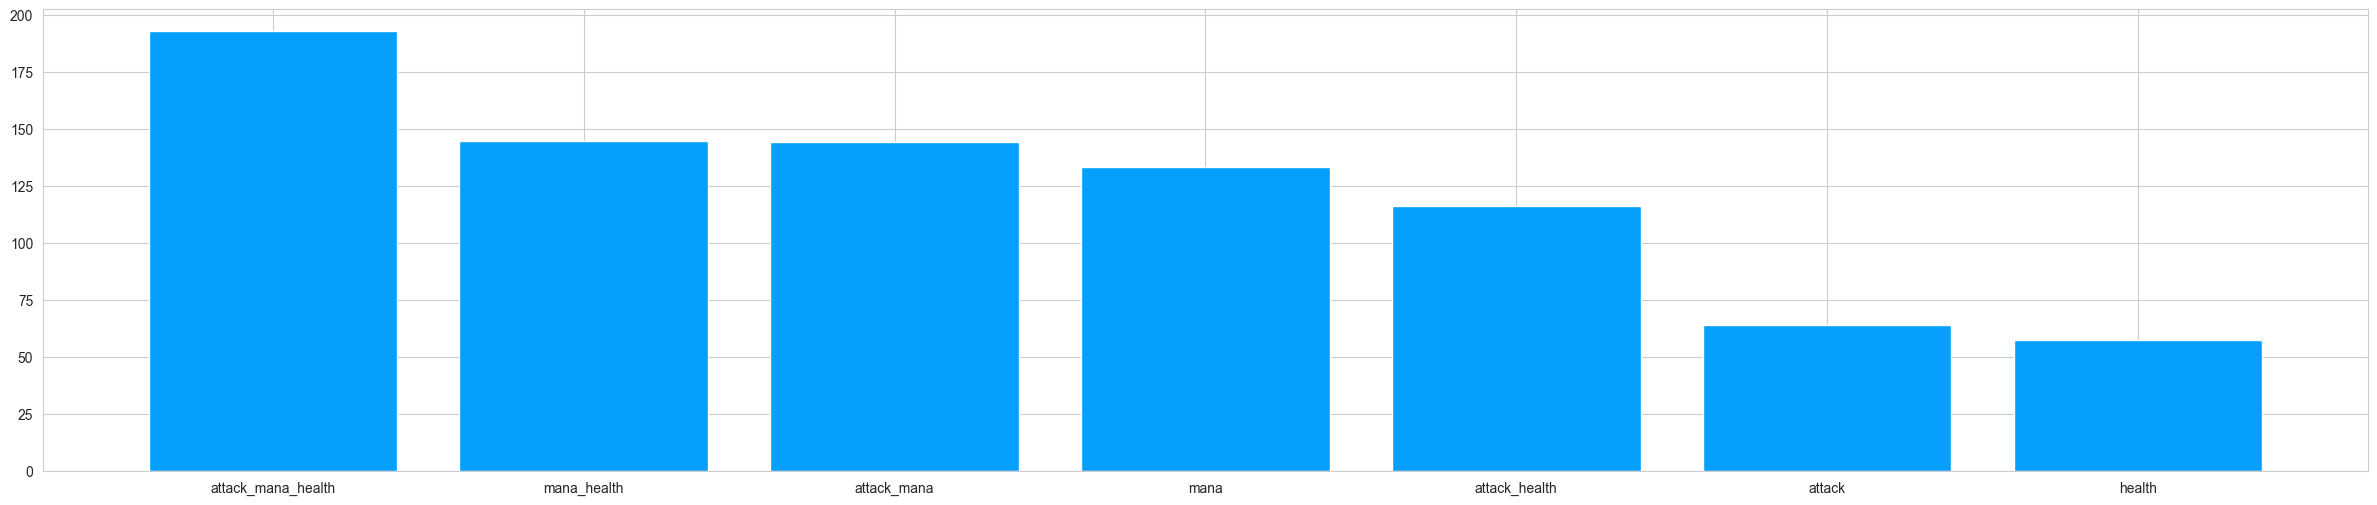

In [89]:
X = train_dataframe.drop(['strategy', 'id'], axis=1)
y = train_dataframe['strategy']

selector = SelectKBest(score_func=chi2)
X_new = selector.fit_transform(X, y)

selected_features = pd.DataFrame(selector.inverse_transform(
    X_new), index=X.index, columns=X.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]

features = zip(selected_columns, selector.scores_)
features = sorted(features, key=lambda x: x[1], reverse=True)
for feature in features:
    print(feature)

plt.figure(figsize=(30, 6))
plt.bar([x[0] for x in features], [x[1] for x in features])
plt.show()

### Mutual Information
The `Mutual Information` method measures the dependency between two variables.

attack_mana_health     0.594774
attack_mana            0.528445
mana_health            0.497340
attack_health          0.445489
health                 0.353338
attack                 0.353102
mana                   0.313210
type_spell             0.133941
att_greater_health     0.044300
god_neutral            0.043349
type_god power         0.022404
att_greater_mana       0.019896
att_greater_5          0.014160
mana_greater_7         0.012033
god_light              0.011220
type_weapon            0.010839
mana_greater_health    0.008111
dtype: float64


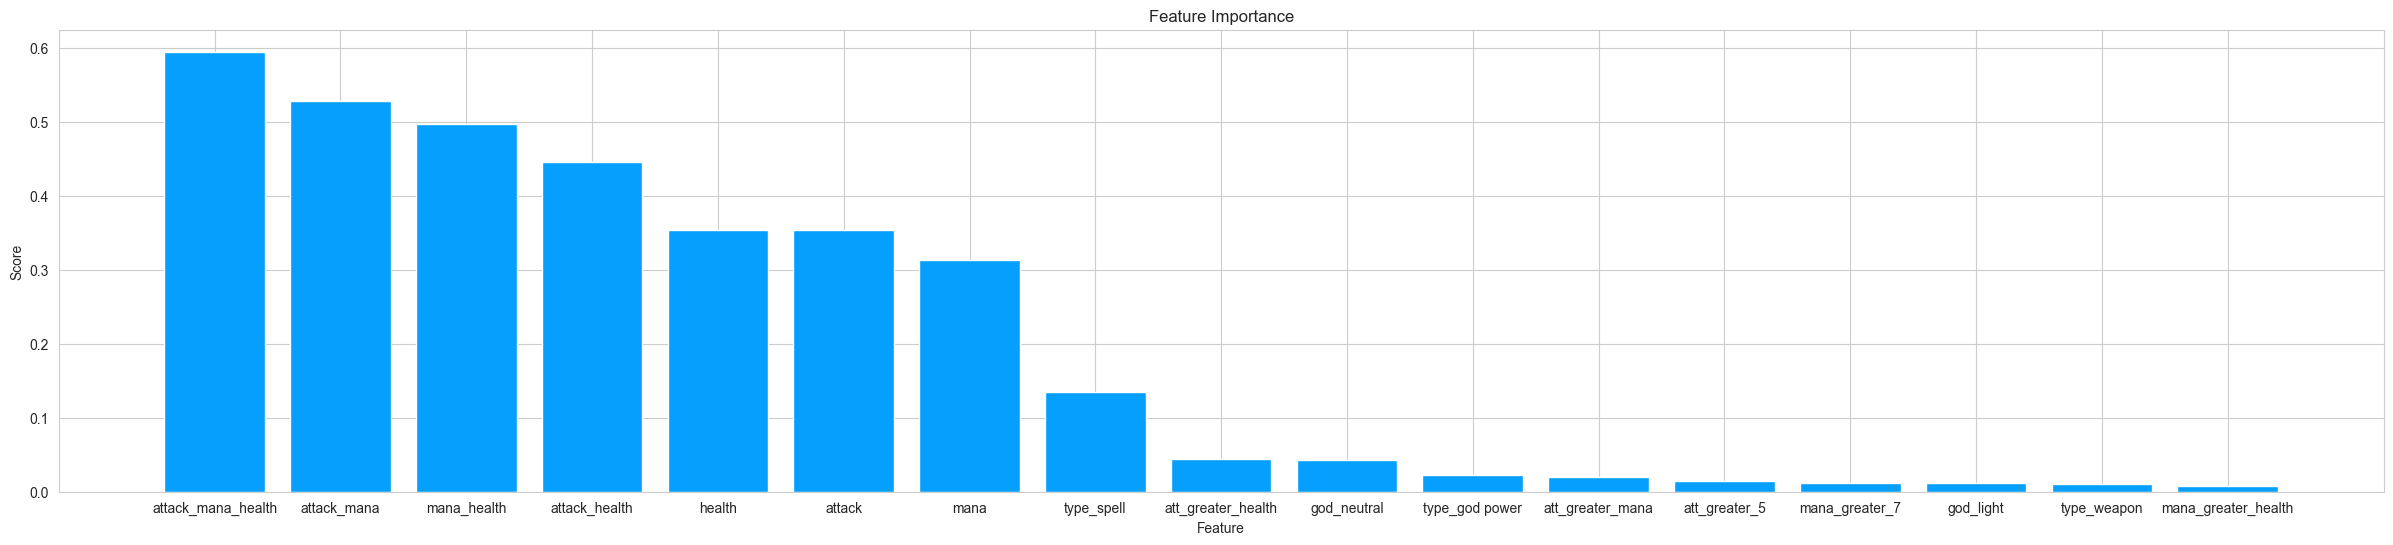

In [90]:
X = train_dataframe.drop(['strategy', 'id'], axis=1)
y = train_dataframe['strategy']

mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info, index=X.columns)
mutual_info = mutual_info[mutual_info > 0]
mutual_info = mutual_info.sort_values(ascending=False)

print(mutual_info)
plt.figure(figsize=(30, 6))
plt.bar(mutual_info.index, mutual_info)
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('Feature Importance')
plt.show()

In [91]:
selected_columns = list(mutual_info.index[:7]) + ['strategy', 'id']
train_dataframe = train_dataframe[selected_columns]
train_dataframe.head()

,attack_mana_health,attack_mana,mana_health,attack_health,health,attack,mana,strategy,id
0,2.079442,1.386294,1.386294,1.386294,0.693147,0.693147,0.693147,False,376
1,3.191523,2.106090,2.222590,2.029280,1.081694,0.950641,1.609438,False,914
2,4.787492,3.178054,2.995732,3.401197,1.609438,1.791759,1.386294,True,263
3,2.995732,2.302585,2.302585,1.386294,0.693147,0.693147,1.609438,True,1057
4,3.191523,2.106090,2.222590,2.029280,1.081694,0.950641,0.693147,False,1123


## Model Building
This section will be dedicated to building the machine learning model.

In [92]:
train_dataframe['strategy'] = train_dataframe['strategy'].astype(int)
train_dataframe.dtypes

attack_mana_health    float64
attack_mana           float64
mana_health           float64
attack_health         float64
health                float64
attack                float64
mana                  float64
strategy                int64
id                      int64
dtype: object

In [93]:
X = train_dataframe.drop(['strategy', 'id'], axis=1)
y = train_dataframe['strategy']

In [94]:
test_dataframe = test_dataframe.sample(
    frac=1,
    random_state=237
).reset_index(drop=True)
test_dataframe['attack'] = test_dataframe['attack'].apply(lambda x: np.log(x))
test_dataframe['mana'] = test_dataframe['mana'].apply(lambda x: np.log(x))
test_dataframe['health'] = test_dataframe['health'].apply(lambda x: np.log(x))

test_dataframe['attack_mana'] = test_dataframe['attack'] + \
    test_dataframe['mana']
test_dataframe['attack_health'] = test_dataframe['attack'] + \
    test_dataframe['health']
test_dataframe['mana_health'] = test_dataframe['mana'] + \
    test_dataframe['health']
test_dataframe['attack_mana_health'] = test_dataframe['attack'] + \
    test_dataframe['mana'] + test_dataframe['health']

test_dataframe['att_greater_5'] = test_dataframe['attack'] > 5
test_dataframe['mana_greater_7'] = test_dataframe['mana'] > 7
test_dataframe['health_greater_6'] = test_dataframe['health'] > 5
test_dataframe['att_greater_mana'] = test_dataframe['attack'] > test_dataframe['mana']
test_dataframe['att_greater_health'] = test_dataframe['attack'] > test_dataframe['health']
test_dataframe['mana_greater_health'] = test_dataframe['mana'] > test_dataframe['health']

test_dataframe['att_greater_5'] = test_dataframe['att_greater_5'].astype(int)
test_dataframe['mana_greater_7'] = test_dataframe['mana_greater_7'].astype(int)
test_dataframe['health_greater_6'] = test_dataframe['health_greater_6'].astype(
    int)
test_dataframe['att_greater_mana'] = test_dataframe['att_greater_mana'].astype(
    int)
test_dataframe['att_greater_health'] = test_dataframe['att_greater_health'].astype(
    int)
test_dataframe['mana_greater_health'] = test_dataframe['mana_greater_health'].astype(
    int)

test_dataframe = pd.get_dummies(
    test_dataframe,
    columns=['god', 'type'],
    drop_first=True,
    prefix=['god', 'type'],
    prefix_sep='_'
)

test_dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
test_dataframe['attack'] = test_dataframe['attack'].fillna(
    test_dataframe['attack'].mean())
test_dataframe['mana'] = test_dataframe['mana'].fillna(
    test_dataframe['mana'].mean())
test_dataframe['health'] = test_dataframe['health'].fillna(
    test_dataframe['health'].mean())
test_dataframe['attack_mana'] = test_dataframe['attack_mana'].fillna(
    test_dataframe['attack_mana'].mean())
test_dataframe['attack_health'] = test_dataframe['attack_health'].fillna(
    test_dataframe['attack_health'].mean())
test_dataframe['mana_health'] = test_dataframe['mana_health'].fillna(
    test_dataframe['mana_health'].mean())
test_dataframe['attack_mana_health'] = test_dataframe['attack_mana_health'].fillna(
    test_dataframe['attack_mana_health'].mean())

ids_test = test_dataframe['id']

columns = selected_columns.copy()
columns.remove('strategy')
columns.remove('id')
test_dataframe = test_dataframe[columns]
test_dataframe.head()

,attack_mana_health,attack_mana,mana_health,attack_health,health,attack,mana
0,5.010635,3.218876,3.401197,3.401197,1.791759,1.609438,1.609438
1,5.971262,3.891820,4.025352,4.025352,2.079442,1.945910,1.945910
2,3.988984,2.890372,2.890372,2.197225,1.098612,1.098612,1.791759
3,3.323568,2.167216,2.302848,2.152668,1.141631,1.008968,0.693147
4,3.323568,2.167216,2.302848,2.152668,1.141631,1.008968,2.079442


In [95]:

test_dataframe = test_dataframe[columns]
test_dataframe.head()

,attack_mana_health,attack_mana,mana_health,attack_health,health,attack,mana
0,5.010635,3.218876,3.401197,3.401197,1.791759,1.609438,1.609438
1,5.971262,3.891820,4.025352,4.025352,2.079442,1.945910,1.945910
2,3.988984,2.890372,2.890372,2.197225,1.098612,1.098612,1.791759
3,3.323568,2.167216,2.302848,2.152668,1.141631,1.008968,0.693147
4,3.323568,2.167216,2.302848,2.152668,1.141631,1.008968,2.079442


### Model Selection
The first step is to select the model that will be used to classify the cards.

We can use a variety of models and compare their performance to select the best one.

That's what I'll do in this section.

In [96]:
models = [
    ('LR', LogisticRegression()),
    ('RF', RandomForestClassifier(bootstrap=False, criterion="entropy",
     max_features=0.55, min_samples_leaf=8, min_samples_split=12, n_estimators=100)),
    ('GB', GradientBoostingClassifier(
        learning_rate=0.1, n_estimators=100, subsample=0.9)),
    ('SVC', SVC()),
    ('LSVC', LinearSVC())
]

results_metrics = []
models_result = []
names = []

### Model Training and Evaluation
The next step is to train the model using the training data.

In this case the `test_dataframe` doesn't have the `strategy` column, so I'll use the `train_dataframe` to train the model and a split of the `train_dataframe` to test the model.

After training the model, I'll use the `test_dataframe` apply the model predictions.

In [97]:
def ks_score(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return max(tpr - fpr)

In [98]:

def plot_performance(_results: list, _names: list) -> None:
    plt.clf()
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Models Performance Comparison')
    plt.ylabel('KS')
    plt.xlabel('Model')

    plt.bar(_names, _results, color=collor_pallet)

    for i, v in enumerate(_results):
        plt.text(x=i-0.1, y=v+0.05, s=str(round(v, 2)), color='black')

    plt.show()

In [99]:

def get_best_model(ks: list, models: list, names: list) -> list:
    name = names[np.argmax(results_metrics)]
    ks = max(results_metrics)
    model = models[np.argmax(results_metrics)]
    print('The best model is {} with KS of {}'.format(name, ks))
    return [name, ks, model]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=237)

LR ks: 0.63
LR accuracy: 0.84
LR f1: 0.78
LR precision: 0.85


RF ks: 0.97
RF accuracy: 0.99
RF f1: 0.98
RF precision: 1.00


GB ks: 1.00
GB accuracy: 1.00
GB f1: 1.00
GB precision: 1.00


SVC ks: 0.62
SVC accuracy: 0.85
SVC f1: 0.77
SVC precision: 1.00


LSVC ks: 0.61
LSVC accuracy: 0.82
LSVC f1: 0.76
LSVC precision: 0.83




<Figure size 640x480 with 0 Axes>

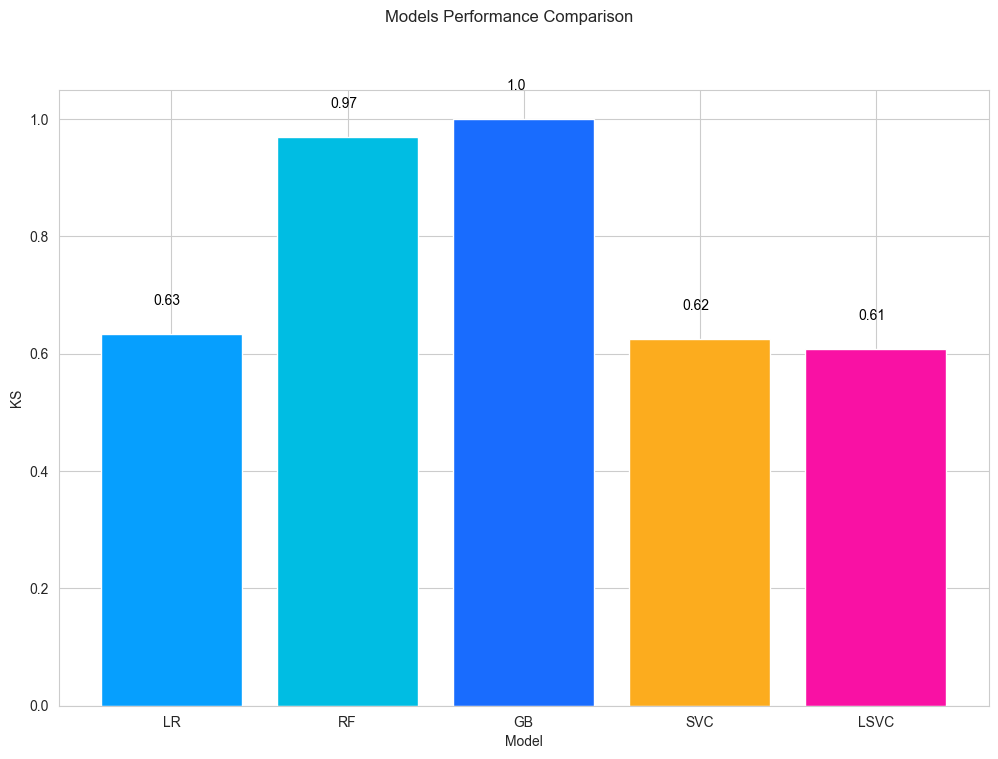

The best model is GB with KS of 1.0


In [101]:
for name, model in models:
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    ks = ks_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    results_metrics.append(ks)
    names.append(name)
    models_result.append(model)

    print(f'{name} ks: {ks:.2f}')
    print(f'{name} accuracy: {accuracy:.2f}')
    print(f'{name} f1: {f1:.2f}')
    print(f'{name} precision: {precision:.2f}')

    # print(classification_report(y_test, y_pred))

    print("\n")

plot_performance(results_metrics, names)
best_model = get_best_model(results_metrics, models_result, names)

Now I'll evaluate the model using the `classification_report` and the `confusion_matrix`.

After I will apply the model in the `test_dataframe` to predict the `strategy` column.

In [102]:
best_model[2].fit(X, y)
y_pred = best_model[2].predict(test_dataframe)

raw_test['strategy'] = y_pred
raw_test['strategy'] = raw_test['strategy'].apply(
    lambda x: 'late' if x == 1 else 'early')

In [103]:
joined_dataframe = pd.concat([raw_test, raw_train], axis=0)
joined_dataframe = joined_dataframe.sort_values(by='id')
joined_dataframe.to_parquet(_path + '/data/cards.parquet', index=False)

In [104]:
joined_dataframe.to_csv(_path + '/data/cards.csv', index=False)